In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
import autograd.numpy as np
import pandas as pd
import cv2
import csv
import pickle
import glob
import time

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

In [2]:
 def load_data(csvname):
    # load in data
    data = np.asarray(pd.read_csv(csvname))

    # import data and reshape appropriately
    X = data[:,0:-1]
    y = data[:,-1]
    y.shape = (len(y),1)
    
    X_square = np.zeros((len(y),28,28))
    for i in range(0,len(y)):
        X_square[i,:,:] = np.reshape(X[i,:],(28,28),1)
    
    # pad data with ones for more compact gradient computation
    #o = np.ones((np.shape(X)[0],1))
    #X = np.concatenate((o,X),axis = 1)
    X = X.T
    
    return X,X_square,y

In [3]:
# load data
X,X_square, y = load_data('../../mlrefined_datasets/convnet_datasets/feat_face_data.csv')

In [4]:
# create HOG-like features for data

# load kernels
kernels = convlib.image_viz.load_kernels()

# params
sliding_window_size= (6,6) 
stride=3
pooling_func= 'max'
normalization = 'l2'

# get number of images in the dataset
num_images = np.shape(X_square)[0]
        
# a test run to find the number of features with the params above
test = convlib.image_viz.make_feat(X_square[0,:,:], kernels, sliding_window_size=sliding_window_size, stride=stride)
num_features = np.shape(test)[0]

                
feat = np.zeros((num_features,num_images))
for i in range(0,num_images):
    # extract features
    feat[:,i] = convlib.image_viz.make_feat(X_square[i,:,:], kernels, sliding_window_size=sliding_window_size,
                                            stride=stride, pooling_func=pooling_func,
                                            normalization=normalization)

# uncomment to pad features with ones (if needed)
#feat = np.concatenate((np.ones((1,num_images)),feat))          

In [5]:
print('number of images: ', np.shape(y)[0])
print('number of raw pixels: ', np.shape(X)[0])
print('number of HOG features: ', np.shape(feat)[0])

number of images:  9999
number of raw pixels:  784
number of HOG features:  512


In [6]:
###### for squared margin cost #######
# function for computing gradient and Hessian for squared margin cost Newton's method
def squared_margin_grad_hess(X,y,w):
    hess = 0
    grad = 0
    for p in range(0,len(y)):
        # precompute        
        x_p = X[:,p]
        y_p = y[p]
        
        # update grad and hessian
        grad+= -2*max(0,1 - y_p*np.dot(x_p.T,w))*y_p*x_p
        
        if 1 - y_p*np.dot(x_p.T,w) > 0:
            hess+= 2*np.outer(x_p,x_p)
        
    grad.shape = (len(grad),1)
    return grad,hess

# run newton's method
def squared_margin_newtons_method(X,y,w):
    # begin newton's method loop    
    max_its = 20
    misclass_history = []
    for k in range(max_its):
        # compute gradient and Hessian
        grad,hess = squared_margin_grad_hess(X,y,w)

        # take Newton step
        hess = hess + 10**-3*np.diag(np.ones((np.shape(X)[0])))
        temp = np.dot(hess,w) - grad        
        w = np.dot(np.linalg.pinv(hess),temp)

        # update history container
        cost = count_misclasses(X,y,w)
        misclass_history.append(cost)
        
        print('iteration:',k+1, '/20')
    
    return misclass_history

In [7]:
# function for counting the number of misclassifications
def count_misclasses(X,y,w):
    y_pred = np.sign(np.dot(X.T,w))
    num_misclassed = len(y) - len([i for i, j in zip(y, y_pred) if i == j])
    return num_misclassed

In [8]:
###### raw pixels #######
w0 = np.random.randn(np.shape(X)[0],1)
squared_margin_history_raw = squared_margin_newtons_method(X,y,w0)

iteration: 1 /20
iteration: 2 /20
iteration: 3 /20
iteration: 4 /20
iteration: 5 /20
iteration: 6 /20
iteration: 7 /20
iteration: 8 /20
iteration: 9 /20
iteration: 10 /20
iteration: 11 /20
iteration: 12 /20
iteration: 13 /20
iteration: 14 /20
iteration: 15 /20
iteration: 16 /20
iteration: 17 /20
iteration: 18 /20
iteration: 19 /20
iteration: 20 /20


In [9]:
###### HOG #######
w0 = np.random.randn(np.shape(feat)[0],1)
squared_margin_history_HOG = squared_margin_newtons_method(feat,y,w0)

iteration: 1 /20
iteration: 2 /20
iteration: 3 /20
iteration: 4 /20
iteration: 5 /20
iteration: 6 /20
iteration: 7 /20
iteration: 8 /20
iteration: 9 /20
iteration: 10 /20
iteration: 11 /20
iteration: 12 /20
iteration: 13 /20
iteration: 14 /20
iteration: 15 /20
iteration: 16 /20
iteration: 17 /20
iteration: 18 /20
iteration: 19 /20
iteration: 20 /20


<IPython.core.display.Javascript object>


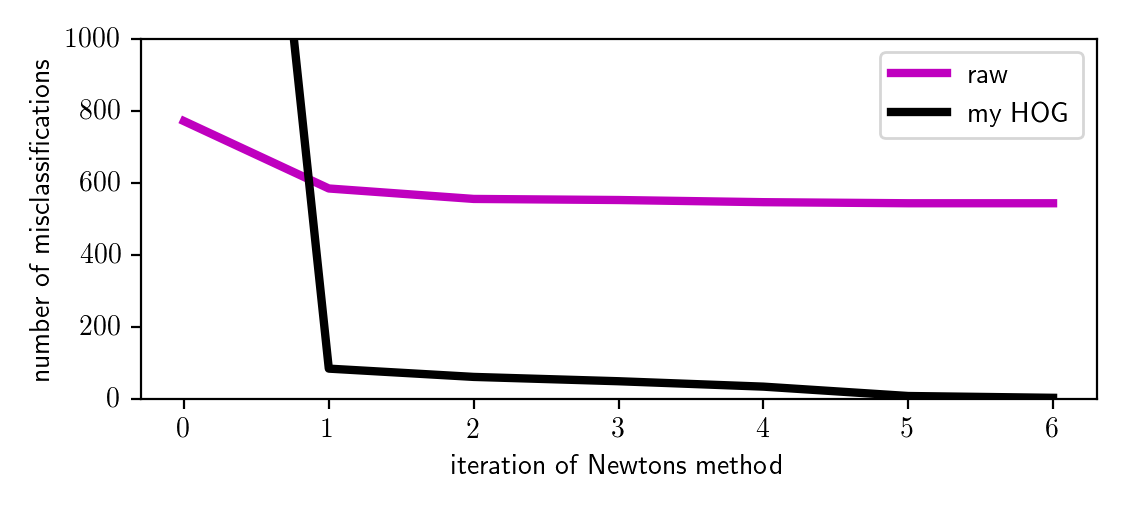

In [16]:
# plot results
plt.plot(squared_margin_history_raw[0:7],color = 'm', linewidth=3)
plt.plot(squared_margin_history_HOG[0:7],'k', linewidth=3)

# clean up plot
plt.ylim([min(min(squared_margin_history_raw),min(squared_margin_history_HOG)) - 1,1000])
plt.xlabel('iteration of Newtons method')
plt.ylabel('number of misclassifications')
plt.legend(['raw','my HOG'])
plt.show()